In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/workshop2/full_campaign_daily_event.csv
/kaggle/input/workshop2/apparel-target_binary.csv
/kaggle/input/workshop2/full_campaign_daily_event_channel.csv
/kaggle/input/workshop2/apparel-messages.csv
/kaggle/input/workshop2/apparel-purchases.csv


# Загрузка данных и библиотек

In [2]:
!pip install phik -q
!pip install shap -q
!pip install catboost -q
!pip install lightgbm -q
!pip install imblearn -q
!pip install xgboost -q

In [38]:
from datetime import datetime
import phik
import ast
import shap
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from ast import literal_eval
from datetime import timedelta
from collections import Counter



import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



pd.set_option('display.max_columns', None)  # чтобы видеть все колонки в выводе

In [4]:
a_mes = pd.read_csv('../input/workshop2/apparel-messages.csv')
a_pur = pd.read_csv('../input/workshop2/apparel-purchases.csv')
a_tb = pd.read_csv('../input/workshop2/apparel-target_binary.csv')
fcde = pd.read_csv('../input/workshop2/full_campaign_daily_event.csv')
fcde_ch = pd.read_csv('../input/workshop2/full_campaign_daily_event_channel.csv')

In [5]:
# Проверим размеры загруженных датасетов
print("apparel_messages:", a_mes.shape)
print("apparel_purchases:", a_pur.shape)
print("apparel_target_binary:", a_tb.shape)
print("full_campaign_daily_event:", fcde.shape)
print("full_campaign_daily_event_channel:", fcde_ch.shape)

apparel_messages: (12739798, 7)
apparel_purchases: (202208, 6)
apparel_target_binary: (49849, 2)
full_campaign_daily_event: (131072, 24)
full_campaign_daily_event_channel: (131072, 36)


<div class="alert-info" style="padding: 20px; border-radius: 10px">  
    
1. Библиотеки: Установлены и импортированы основные библиотеки для анализа данных, визуализации и машинного обучения (pandas, numpy, matplotlib, seaborn, sklearn, phik, lightgbm, xgboost, catboost, imblearn).

2. Данные: Загружены 5 CSV-файлов с размерами:

    - apparel_messages.csv: 12,379,798 строк, 7 столбцов
    - apparel_purchases.csv: 202,248 строк, 6 столбцов
    - apparel_target_binary.csv: 49,849 строк, 2 столбца
    - full_campaign_daily_event.csv: 131,072 строки, 24 столбца
    - full_campaign_daily_event_channel.csv: 131,072 строки, 36 столбцов


3. Структура: Данные подготовлены для работы с большими объемами информации, а настройка отображения столбцов упрощает анализ.


</div>

# Исследовательский анализ данных

In [6]:
# Проверка количества дубликатов в датасетах
duplicates_count = {
    "apparel_purchases": a_pur.duplicated().sum(),
    "apparel_messages": a_mes.duplicated().sum(),
    "apparel_target_binary": a_tb.duplicated().sum(),
    "full_campaign_daily_event": fcde.duplicated().sum(),
    "full_campaign_daily_event_channel": fcde_ch.duplicated().sum(),
}

duplicates_count

{'apparel_purchases': 73020,
 'apparel_messages': 48610,
 'apparel_target_binary': 0,
 'full_campaign_daily_event': 0,
 'full_campaign_daily_event_channel': 0}

In [7]:
def basic_eda(df, df_name):
    print(f"\n=== {df_name} ===")
    display(df.head())
    print(df.info())
    display(df.describe(include='all'))
    print("="*40)
    print("Количество пропусков:\n", df.isna().sum())

In [8]:
basic_eda(a_mes, "apparel_messages")


=== apparel_messages ===


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798,12739798,12739798,12739798
unique,NaN,NaN,9061667,11,2,638,4103539
top,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,2023-06-10,2023-12-29 15:20:53
freq,NaN,NaN,1454,9058196,7512156,89661,621
mean,1.160459e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN
std,3.259211e+03,3.265518e+08,NaN,NaN,NaN,NaN,NaN
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,NaN,NaN
25%,8.746000e+03,1.515916e+18,NaN,NaN,NaN,NaN,NaN
50%,1.351600e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN
75%,1.415800e+04,1.515916e+18,NaN,NaN,NaN,NaN,NaN


Количество пропусков:
 bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


In [9]:
basic_eda(a_pur, "apparel_purchases")


=== apparel_purchases ===


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,client_id,quantity,price,category_ids,date,message_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208,202208
unique,NaN,NaN,NaN,933,642,50204
top,NaN,NaN,NaN,"['4', '28', '57', '431']",2022-11-11,1515915625489095763-6251-6311b13a4cf78
freq,NaN,NaN,NaN,8626,5270,365
mean,1.515916e+18,1.006483,1193.301516,NaN,NaN,NaN
std,1.459514e+08,0.184384,1342.252664,NaN,NaN,NaN
min,1.515916e+18,1.000000,1.000000,NaN,NaN,NaN
25%,1.515916e+18,1.000000,352.000000,NaN,NaN,NaN
50%,1.515916e+18,1.000000,987.000000,NaN,NaN,NaN
75%,1.515916e+18,1.000000,1699.000000,NaN,NaN,NaN


Количество пропусков:
 client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


In [10]:
basic_eda(a_tb, "apparel_target_binary")


=== apparel_target_binary ===


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


Количество пропусков:
 client_id    0
target       0
dtype: int64


In [11]:
# basic_eda(fcde, "full_campaign_daily_event")

In [12]:
# basic_eda(fcde_ch, "full_campaign_daily_event_channel")

In [13]:
# Преобразуем даты в формат datetime
a_pur["date"] = pd.to_datetime(a_pur["date"])
a_mes["date"] = pd.to_datetime(a_mes["date"])
a_mes["created_at"] = pd.to_datetime(a_mes["created_at"])
fcde["date"] = pd.to_datetime(fcde["date"])
fcde_ch["date"] = pd.to_datetime(fcde_ch["date"])

In [14]:
def parse_categories(x):
    try:
        # Если x уже NaN или пустое, возвращаем пустой список
        if pd.isna(x):
            return []
        return ast.literal_eval(x)
    except Exception as e:
        # Если не удалось распарсить, вернём пустой список 
        return []

# Создаём новый столбец со списками категорий
a_pur['cat_list'] = a_pur['category_ids'].apply(parse_categories)

# Пример просмотра результата
display(a_pur[['category_ids', 'cat_list']].head())

,category_ids,cat_list
0,"['4', '28', '57', '431']","[4, 28, 57, 431]"
1,"['4', '28', '57', '431']","[4, 28, 57, 431]"
2,"['4', '28', '57', '431']","[4, 28, 57, 431]"
3,"['4', '28', '244', '432']","[4, 28, 244, 432]"
4,"['4', '28', '49', '413']","[4, 28, 49, 413]"


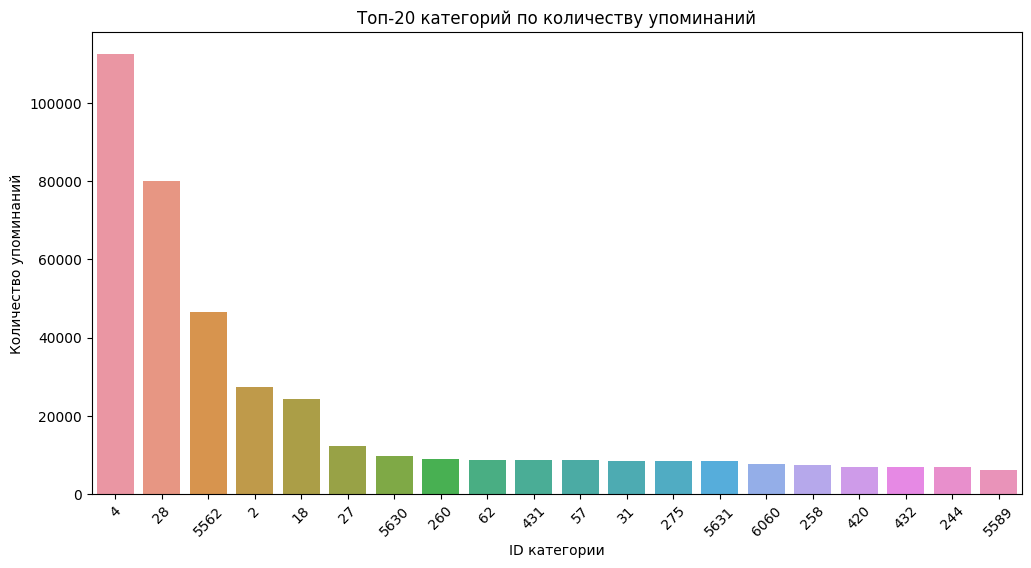

In [15]:
# Построим график самых часто встречающихся категорий
# "Разворачиваем" списки категорий в один список
all_categories = [cat for sublist in a_pur['cat_list'] for cat in sublist]
cat_counts = pd.Series(all_categories).value_counts().reset_index()
cat_counts.columns = ['category_id', 'count']

plt.figure(figsize=(12,6))
sns.barplot(x='category_id', y='count', data=cat_counts.head(20))
plt.title("Топ-20 категорий по количеству упоминаний")
plt.xlabel("ID категории")
plt.ylabel("Количество упоминаний")
plt.xticks(rotation=45)
plt.show()

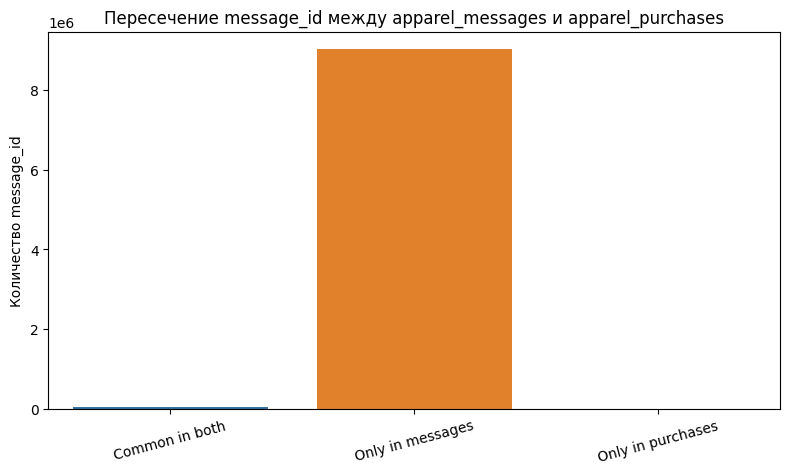

In [16]:
# Подготовка данных
message_ids_in_messages = set(a_mes["message_id"].unique())
message_ids_in_purchases = set(a_pur["message_id"].unique())
common_message_ids = message_ids_in_messages.intersection(message_ids_in_purchases)

n_common = len(common_message_ids)
n_only_messages = len(message_ids_in_messages - message_ids_in_purchases)
n_only_purchases = len(message_ids_in_purchases - message_ids_in_messages)

intersection_data = pd.DataFrame({
    "category": ["Common in both", "Only in messages", "Only in purchases"],
    "count": [n_common, n_only_messages, n_only_purchases]
})

# Barplot
plt.figure(figsize=(8,5))
sns.barplot(data=intersection_data, x="category", y="count")
plt.title("Пересечение message_id между apparel_messages и apparel_purchases")
plt.xlabel("")
plt.ylabel("Количество message_id")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

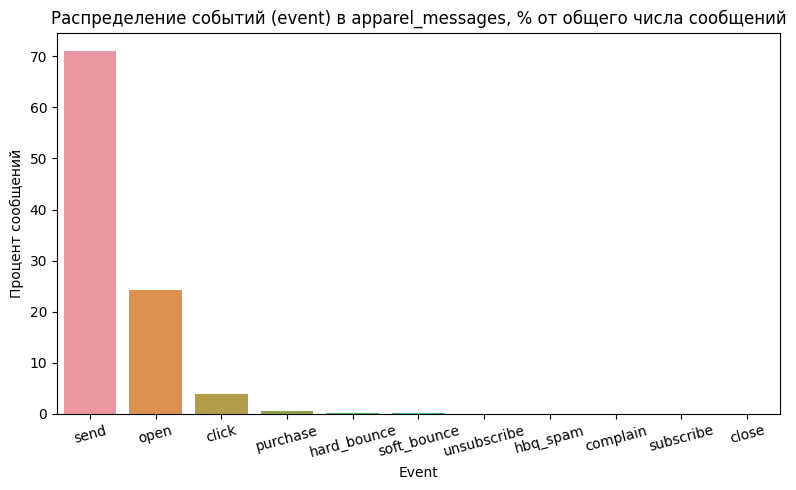

In [17]:
event_distribution = a_mes["event"].value_counts()
channel_distribution = a_mes["channel"].value_counts()
total_rows = len(a_mes)  # общее число строк в apparel_messages

# Переводим в проценты
event_distribution_percent = (event_distribution / total_rows) * 100

plt.figure(figsize=(8,5))
sns.barplot(x=event_distribution_percent.index, y=event_distribution_percent.values)
plt.title("Распределение событий (event) в apparel_messages, % от общего числа сообщений")
plt.xlabel("Event")
plt.ylabel("Процент сообщений")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

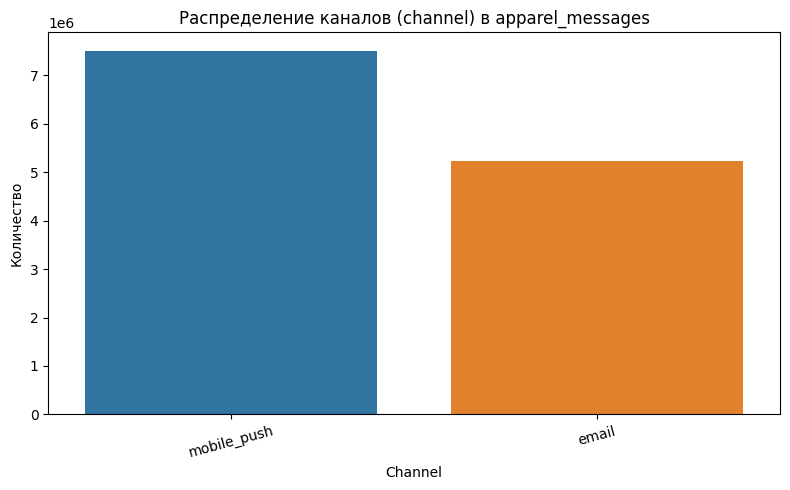

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=channel_distribution.index, 
    y=channel_distribution.values
)
plt.title("Распределение каналов (channel) в apparel_messages")
plt.xlabel("Channel")
plt.ylabel("Количество")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


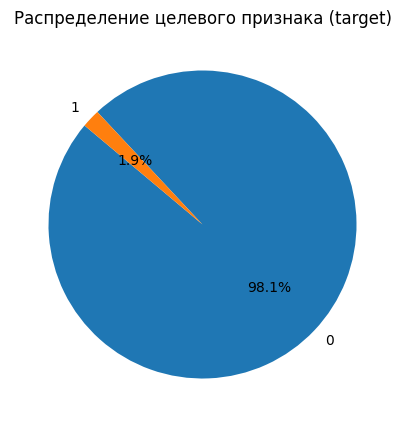

In [19]:
target_counts = a_tb['target'].value_counts().reset_index()
target_counts.columns = ['target_value', 'count']

plt.figure(figsize=(5,5))
plt.pie(
    target_counts['count'], 
    labels=target_counts['target_value'], 
    autopct='%.1f%%', 
    startangle=140
)
plt.title("Распределение целевого признака (target)")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


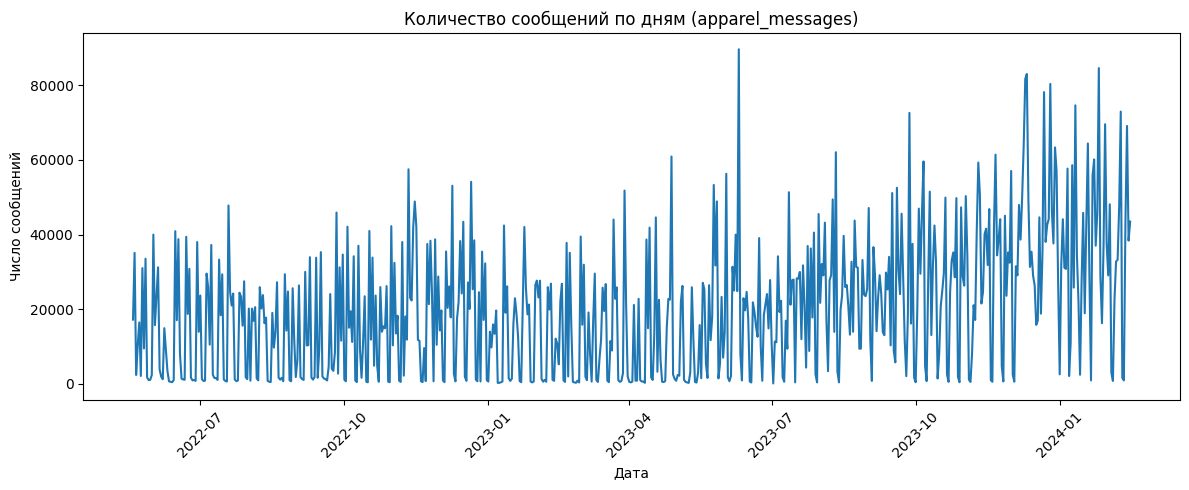

In [20]:
# Преобразуем колонку 'date' в datetime, если не сделали этого раньше
a_mes['date'] = pd.to_datetime(a_mes['date'], errors='coerce')

# Группируем по датам (ежедневно) и считаем количество событий
daily_messages = a_mes.groupby(a_mes['date'].dt.date).size().reset_index(name='count')

plt.figure(figsize=(12,5))
sns.lineplot(data=daily_messages, x='date', y='count')
plt.title("Количество сообщений по дням (apparel_messages)")
plt.xlabel("Дата")
plt.ylabel("Число сообщений")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


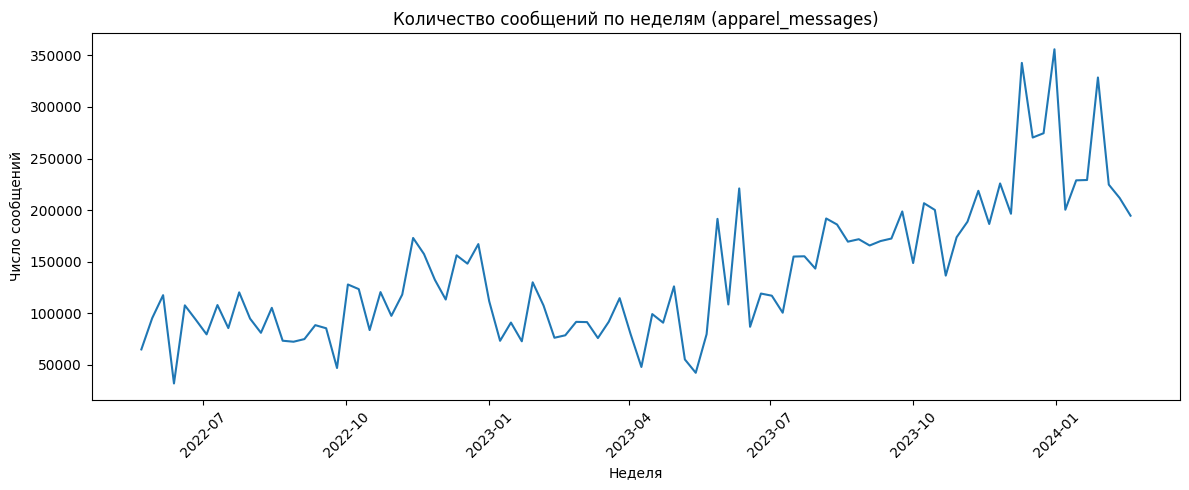

In [21]:
# Пример группировки по неделям (часто удобнее для крупного периода)
weekly_messages = a_mes.groupby(pd.Grouper(key='date', freq='W')).size().reset_index(name='count')

plt.figure(figsize=(12,5))
sns.lineplot(data=weekly_messages, x='date', y='count')
plt.title("Количество сообщений по неделям (apparel_messages)")
plt.xlabel("Неделя")
plt.ylabel("Число сообщений")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

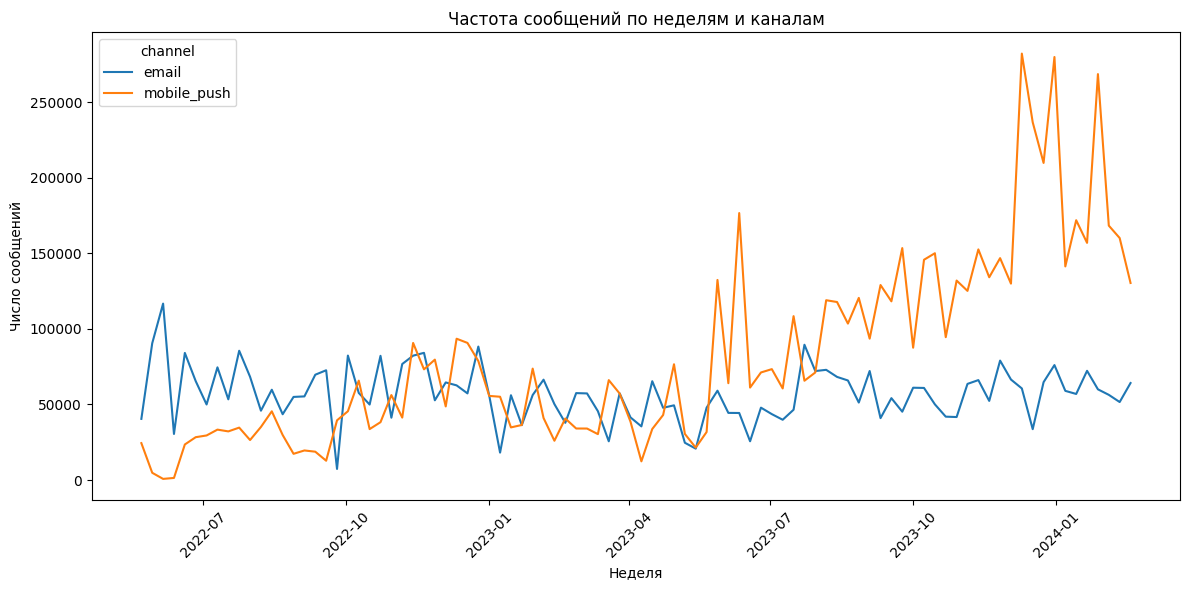

In [22]:
messages_df = a_mes.copy()
messages_df['date'] = pd.to_datetime(messages_df['date'], errors='coerce')

weekly_channel = (
    messages_df
    .groupby([pd.Grouper(key='date', freq='W'), 'channel'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12,6))
sns.lineplot(data=weekly_channel, x='date', y='count', hue='channel')
plt.title("Частота сообщений по неделям и каналам")
plt.xlabel("Неделя")
plt.ylabel("Число сообщений")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div class="alert-info" style="padding: 20px; border-radius: 10px">  

1. Дубликаты в данных:
    - Выявлено значительное количество дубликатов в таблицах:
        - apparel_purchases: 73,020
        - apparel_messages: 46,810
    - В других таблицах дубликаты отсутствуют.

2. Пропуски и структура данных:
    - Пропусков в таблицах почти нет (за исключением отдельных полей в агрегационных таблицах).
    - В apparel_purchases данные о категориях товаров успешно преобразованы в список.

3. Распределение событий и каналов:
    - В apparel_messages большинство событий — отправка сообщений (70%), за ними следуют открытия (~20%).
    - Основные каналы: mobile_push (~70% сообщений) и email (~30%).

4. Целевой признак:
    - target сильно несбалансирован: ~98% отрицательных меток (покупка не произошла).

5. Группировка по времени:
    - Сообщения отправлялись регулярно в течение всего периода.
    - Количество сообщений по неделям увеличивалось ближе к концу наблюдений.
    - mobile_push стабильно преобладал над email.

</div>

# Создание признаков

In [23]:
# Копируем исходные DataFrame, чтобы не трогать оригинал
purchases_df = a_pur.copy()
messages_df = a_mes.copy()

# Преобразуем даты
purchases_df["date"] = pd.to_datetime(purchases_df["date"], errors="coerce")
messages_df["date"] = pd.to_datetime(messages_df["date"], errors="coerce")

# --- 1.1 Базовые признаки покупок ---
purchase_features = purchases_df.groupby("client_id").agg(
    total_purchases=("quantity", "sum"),        # Общее количество покупок
    total_spent=("price", "sum"),              # Общая сумма покупок
    avg_spent_per_purchase=("price", "mean"),  # Средний чек
    unique_categories=("category_ids", lambda x: len(set(x))),
    last_purchase_date=("date", "max")
).reset_index()

current_date_pur = purchases_df["date"].max()
purchase_features["days_since_last_purchase"] = (
    current_date_pur - purchase_features["last_purchase_date"]
).dt.days

# Удалим last_purchase_date
purchase_features.drop(columns=["last_purchase_date"], inplace=True)

print("\nАгрегированные признаки покупок (top 5):")
display(purchase_features.head())


Агрегированные признаки покупок (top 5):


,client_id,total_purchases,total_spent,avg_spent_per_purchase,unique_categories,days_since_last_purchase
0,1515915625468060902,7,6993.0,999.000000,5,630
1,1515915625468061003,7,16235.0,2319.285714,1,408
2,1515915625468061099,1,299.0,299.000000,1,640
3,1515915625468061100,2,2098.0,1049.000000,1,6
4,1515915625468061170,19,33601.0,1768.473684,4,244


In [24]:
# --- 1.2 Базовые признаки сообщений ---
message_features = messages_df.groupby("client_id").agg(
    total_messages_sent=("event", lambda x: (x == "send").sum()),
    total_messages_opened=("event", lambda x: (x == "open").sum()),
    total_messages_clicked=("event", lambda x: (x == "click").sum()),
    last_message_date=("date", "max")
).reset_index()

current_date_mes = messages_df["date"].max()
message_features["days_since_last_message"] = (
    current_date_mes - message_features["last_message_date"]
).dt.days

message_features["open_rate"] = np.where(
    message_features["total_messages_sent"] > 0,
    message_features["total_messages_opened"] / message_features["total_messages_sent"],
    0
)
message_features["click_rate"] = np.where(
    message_features["total_messages_sent"] > 0,
    message_features["total_messages_clicked"] / message_features["total_messages_sent"],
    0
)

# Удаляем last_message_date, если не нужен дальше
message_features.drop(columns=["last_message_date"], inplace=True)

print("\nАгрегированные признаки рассылок (top 5):")
display(message_features.head())


Агрегированные признаки рассылок (top 5):


,client_id,total_messages_sent,total_messages_opened,total_messages_clicked,days_since_last_message,open_rate,click_rate
0,1515915625468060902,126,35,10,27,0.277778,0.079365
1,1515915625468061003,154,5,6,2,0.032468,0.038961
2,1515915625468061099,215,51,8,2,0.237209,0.037209
3,1515915625468061100,267,163,1,0,0.610487,0.003745
4,1515915625468061170,243,31,16,0,0.127572,0.065844


In [25]:
# Определим последний день в данных покупок как "текущую дату" 
max_date_purchases = purchases_df["date"].max()

# Для удобства напишем функцию
def purchases_in_recent_period(df, days):
    """
    Возвращает агрегированные (количество и сумма) покупок
    за последние `days` дней по каждому client_id.
    """
    start_date = max_date_purchases - timedelta(days=days)
    df_period = df[df["date"] >= start_date]
    
    agg_df = df_period.groupby("client_id").agg(
        **{
            f"purchases_{days}d": ("quantity", "sum"),
            f"spent_{days}d": ("price", "sum")
        }
    ).reset_index()
    return agg_df

# Создаём по 3 периодам (30, 60, 90)
purchases_30d = purchases_in_recent_period(purchases_df, 30)
purchases_60d = purchases_in_recent_period(purchases_df, 60)
purchases_90d = purchases_in_recent_period(purchases_df, 90)

# Объединим эти агрегаты с purchase_features
purchase_features_ext = purchase_features.copy()
for df_agg in [purchases_30d, purchases_60d, purchases_90d]:
    purchase_features_ext = purchase_features_ext.merge(df_agg, on="client_id", how="left")

# Заполним пропуски нулями (если для данного клиента не было покупок в период)
purchase_features_ext.fillna(0, inplace=True)
display(purchase_features_ext.head())

,client_id,total_purchases,total_spent,avg_spent_per_purchase,unique_categories,days_since_last_purchase,purchases_30d,spent_30d,purchases_60d,spent_60d,purchases_90d,spent_90d
0,1515915625468060902,7,6993.0,999.000000,5,630,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,7,16235.0,2319.285714,1,408,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625468061099,1,299.0,299.000000,1,640,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625468061100,2,2098.0,1049.000000,1,6,2.0,2098.0,2.0,2098.0,2.0,2098.0
4,1515915625468061170,19,33601.0,1768.473684,4,244,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Выбираем топ-15 самых частотных категорий
all_cats = a_pur['cat_list'].explode().dropna()  # превращаем списки в один столбец
top_categories = all_cats.value_counts().head(15).index

# 4. Фильтруем списки, оставляя только категории из топ-15
def filter_top_cats(cat_list, top_cats=top_categories):
    # Пересечение множества категорий клиента с множеством топовых категорий
    return list(set(cat_list).intersection(set(top_cats)))

a_pur['cat_list_top'] = a_pur['cat_list'].apply(filter_top_cats)

# 5. Создаём мульти-хот (multi-hot) признаки
mlb = MultiLabelBinarizer()
cat_encoded = mlb.fit_transform(a_pur['cat_list_top'])  # матрица 0/1

# 6. Превращаем в DataFrame и добавляем client_id
cat_encoded_df = pd.DataFrame(cat_encoded, columns=mlb.classes_)
cat_encoded_df['client_id'] = a_pur['client_id']

# 7. Агрегируем по client_id, суммируя вхождения каждой категории
# (если одна и та же категория встречается много раз — получим общее число вхождений)
cat_agg = cat_encoded_df.groupby('client_id').sum().reset_index()

# 8. Присоединяем к уже созданному датафрейму с признаками (purchase_features_ext)
purchase_features_ext = purchase_features_ext.merge(cat_agg, on='client_id', how='left')

# Заполняем пропуски нулями (если у клиента не было ни одной топ-категории)
purchase_features_ext.fillna(0, inplace=True)

# Проверяем результат
print(purchase_features_ext.shape)
display(purchase_features_ext.head())

(49849, 27)


,client_id,total_purchases,total_spent,avg_spent_per_purchase,unique_categories,days_since_last_purchase,purchases_30d,spent_30d,purchases_60d,spent_60d,purchases_90d,spent_90d,18,2,260,27,275,28,31,4,431,5562,5630,5631,57,6060,62
0,1515915625468060902,7,6993.0,999.000000,5,630,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,3,0,4,0,7,0,0,0,0,0,0,0
1,1515915625468061003,7,16235.0,2319.285714,1,408,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,7,0,7,0,0,0,0,0,0,0
2,1515915625468061099,1,299.0,299.000000,1,640,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,1515915625468061100,2,2098.0,1049.000000,1,6,2.0,2098.0,2.0,2098.0,2.0,2098.0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0
4,1515915625468061170,19,33601.0,1768.473684,4,244,0.0,0.0,0.0,0.0,0.0,0.0,2,2,12,0,0,15,0,15,0,0,0,0,0,0,0


In [27]:
max_date_messages = messages_df["date"].max()

def messages_in_recent_period(df, days):
    """Считаем send, open, click за последние days дней."""
    start_date = max_date_messages - timedelta(days=days)
    df_period = df[df["date"] >= start_date]
    agg_df = df_period.groupby("client_id").agg(
        **{
            f"msgs_sent_{days}d": ("event", lambda x: (x == "send").sum()),
            f"msgs_open_{days}d": ("event", lambda x: (x == "open").sum()),
            f"msgs_click_{days}d": ("event", lambda x: (x == "click").sum()),
        }
    ).reset_index()
    return agg_df

messages_30d = messages_in_recent_period(messages_df, 30)
messages_60d = messages_in_recent_period(messages_df, 60)
messages_90d = messages_in_recent_period(messages_df, 90)

message_features_ext = message_features.copy()
for df_agg in [messages_30d, messages_60d, messages_90d]:
    message_features_ext = message_features_ext.merge(df_agg, on="client_id", how="left")

message_features_ext.fillna(0, inplace=True)
display(message_features_ext.head())

,client_id,total_messages_sent,total_messages_opened,total_messages_clicked,days_since_last_message,open_rate,click_rate,msgs_sent_30d,msgs_open_30d,msgs_click_30d,msgs_sent_60d,msgs_open_60d,msgs_click_60d,msgs_sent_90d,msgs_open_90d,msgs_click_90d
0,1515915625468060902,126,35,10,27,0.277778,0.079365,2.0,1.0,0.0,11.0,5.0,2.0,20.0,6.0,2.0
1,1515915625468061003,154,5,6,2,0.032468,0.038961,5.0,0.0,0.0,11.0,0.0,0.0,17.0,1.0,1.0
2,1515915625468061099,215,51,8,2,0.237209,0.037209,12.0,1.0,0.0,21.0,1.0,0.0,29.0,1.0,0.0
3,1515915625468061100,267,163,1,0,0.610487,0.003745,24.0,21.0,1.0,45.0,39.0,1.0,69.0,61.0,1.0
4,1515915625468061170,243,31,16,0,0.127572,0.065844,39.0,0.0,0.0,77.0,0.0,0.0,109.0,7.0,0.0


In [28]:
# 3.1 Соединяем расширенные purchase_features_ext и message_features_ext
merged_features_ext = purchase_features_ext.merge(
    message_features_ext, 
    on="client_id", 
    how="outer"
).fillna(0)

# 3.2 Добавляем target
merged_features_ext = merged_features_ext.merge(a_tb, on="client_id", how="left").fillna(0)

# Смотрим, что получилось
print(merged_features_ext.shape)
display(merged_features_ext.head())

(61196, 43)


,client_id,total_purchases,total_spent,avg_spent_per_purchase,unique_categories,days_since_last_purchase,purchases_30d,spent_30d,purchases_60d,spent_60d,purchases_90d,spent_90d,18,2,260,27,275,28,31,4,431,5562,5630,5631,57,6060,62,total_messages_sent,total_messages_opened,total_messages_clicked,days_since_last_message,open_rate,click_rate,msgs_sent_30d,msgs_open_30d,msgs_click_30d,msgs_sent_60d,msgs_open_60d,msgs_click_60d,msgs_sent_90d,msgs_open_90d,msgs_click_90d,target
0,1515915625468060902,7.0,6993.0,999.000000,5.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,4.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,35.0,10.0,27.0,0.277778,0.079365,2.0,1.0,0.0,11.0,5.0,2.0,20.0,6.0,2.0,0.0
1,1515915625468061003,7.0,16235.0,2319.285714,1.0,408.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.0,5.0,6.0,2.0,0.032468,0.038961,5.0,0.0,0.0,11.0,0.0,0.0,17.0,1.0,1.0,1.0
2,1515915625468061099,1.0,299.0,299.000000,1.0,640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,51.0,8.0,2.0,0.237209,0.037209,12.0,1.0,0.0,21.0,1.0,0.0,29.0,1.0,0.0,0.0
3,1515915625468061100,2.0,2098.0,1049.000000,1.0,6.0,2.0,2098.0,2.0,2098.0,2.0,2098.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.0,163.0,1.0,0.0,0.610487,0.003745,24.0,21.0,1.0,45.0,39.0,1.0,69.0,61.0,1.0,0.0
4,1515915625468061170,19.0,33601.0,1768.473684,4.0,244.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,12.0,0.0,0.0,15.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0,31.0,16.0,0.0,0.127572,0.065844,39.0,0.0,0.0,77.0,0.0,0.0,109.0,7.0,0.0,0.0


In [29]:
merged_features_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61196 entries, 0 to 61195
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 61196 non-null  int64  
 1   total_purchases           61196 non-null  float64
 2   total_spent               61196 non-null  float64
 3   avg_spent_per_purchase    61196 non-null  float64
 4   unique_categories         61196 non-null  float64
 5   days_since_last_purchase  61196 non-null  float64
 6   purchases_30d             61196 non-null  float64
 7   spent_30d                 61196 non-null  float64
 8   purchases_60d             61196 non-null  float64
 9   spent_60d                 61196 non-null  float64
 10  purchases_90d             61196 non-null  float64
 11  spent_90d                 61196 non-null  float64
 12  18                        61196 non-null  float64
 13  2                         61196 non-null  float64
 14  260   

<div class="alert-info" style="padding: 20px; border-radius: 10px">  

1. Базовые признаки покупок:
    - Агрегированы данные по клиентам: общее количество и сумма покупок, средний чек, количество уникальных категорий товаров и время с момента последней покупки.
    - Добавлены признаки для 30, 60 и 90-дневных периодов (количество покупок и их суммы).

2. Признаки сообщений:
    - Вычислено общее количество отправленных, открытых и кликнутых сообщений.
    - Рассчитаны коэффициенты открываемости (open_rate) и кликабельности (click_rate).
    - Добавлены признаки активности клиентов за последние 30, 60 и 90 дней.

3. Категории товаров:
    - Выделены топ-15 категорий товаров.
    - Создан multi-hot-признак, отражающий присутствие клиента в каждой из этих категорий.

4. Объединение данных:
    - Сформирован финальный датафрейм из объединённых признаков покупок и сообщений с целевым признаком (target).
    - Итоговый датафрейм содержит 61,196 записей и 43 столбца, включая целевой признак.

</div>

# Корреляционный анализ данных

Колонки, участвующие в Phi_k: ['total_purchases', 'unique_categories', 'days_since_last_purchase', 'purchases_30d', 'spent_30d', 'purchases_60d', 'spent_60d', 'purchases_90d', 'spent_90d', '2', '27', '28', '4', '5562', '5631', 'total_messages_sent', 'total_messages_opened', 'total_messages_clicked', 'days_since_last_message', 'msgs_open_30d', 'msgs_click_30d', 'msgs_open_60d', 'msgs_click_60d', 'msgs_open_90d', 'msgs_click_90d', 'target']


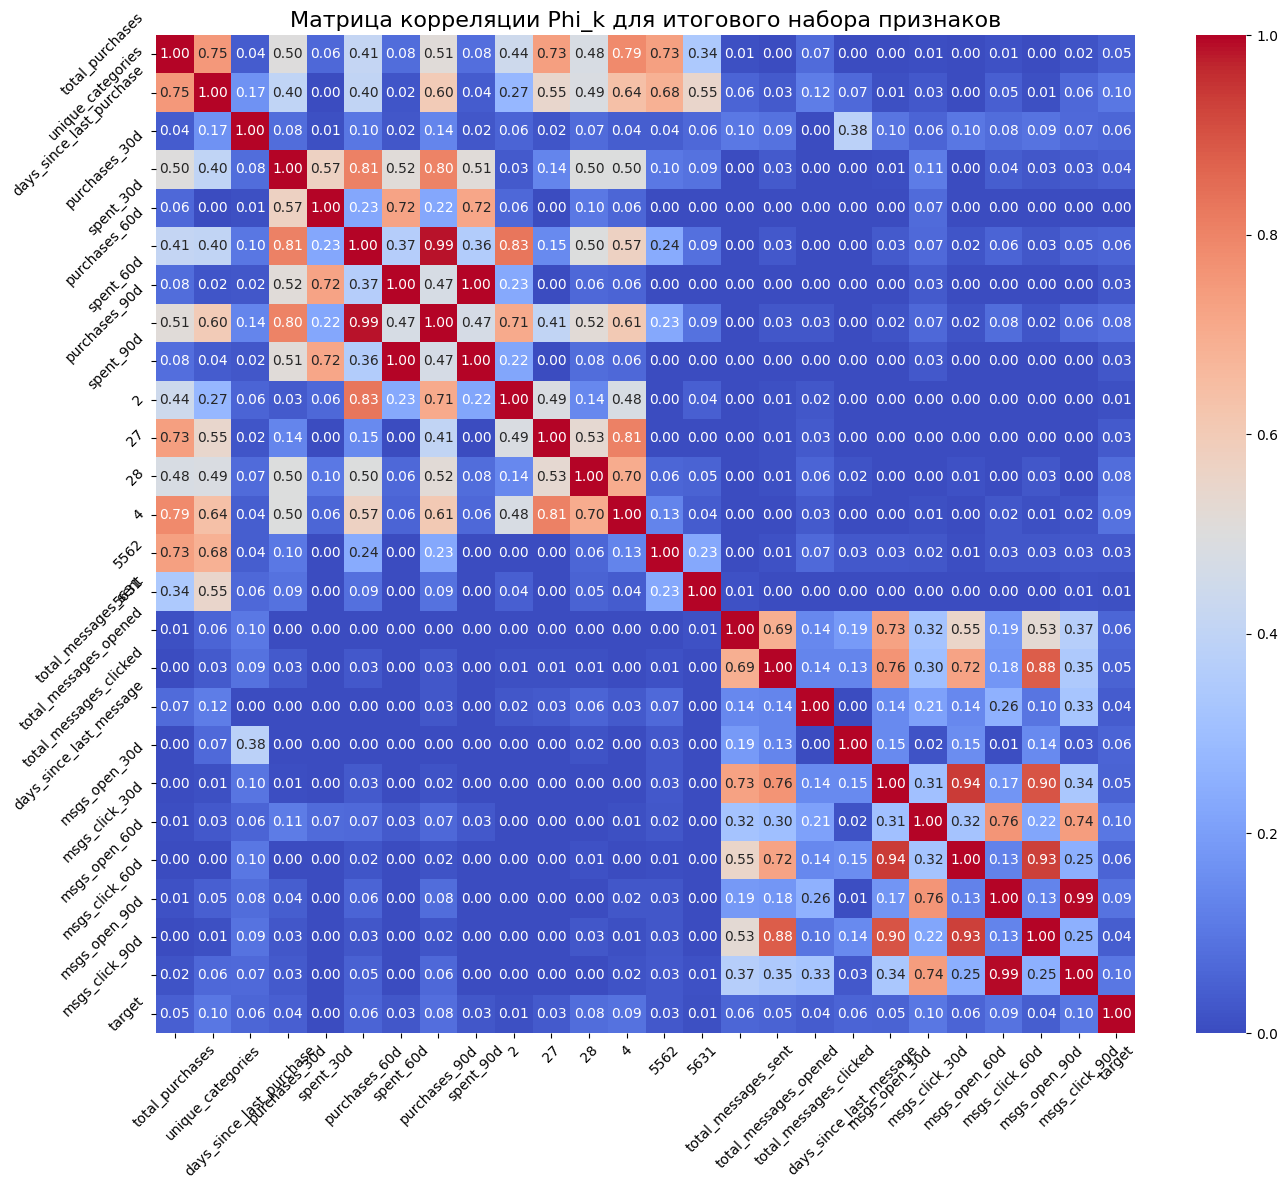

In [44]:
df = merged_features_ext.copy()

# 1. Удаляем столбцы, которые не хотим включать в анализ (например, client_id)
cols_to_drop = ['client_id']
df_cleaned = df.drop(columns=cols_to_drop, axis=1, errors='ignore')

# 2. Определяем столбцы, которые хотим считать числовыми (интервальными)
#    Можно либо задать вручную, либо взять все столбцы типа int/float
interval_cols = df_cleaned.select_dtypes(include=['int64','float64']).columns.tolist()

# Если хотите, можно исключить target, если нужно смотреть только на признаки:
# interval_cols.remove('target')  # при желании убрать, если не хотим correlation с target

print("Колонки, участвующие в Phi_k:", interval_cols)

# 3. Вычисляем матрицу Phi_k
phi_k_matrix = df_cleaned.phik_matrix(interval_cols=interval_cols)

# 4. Визуализируем
plt.figure(figsize=(14, 12))
sns.heatmap(phi_k_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляции Phi_k для итогового набора признаков", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

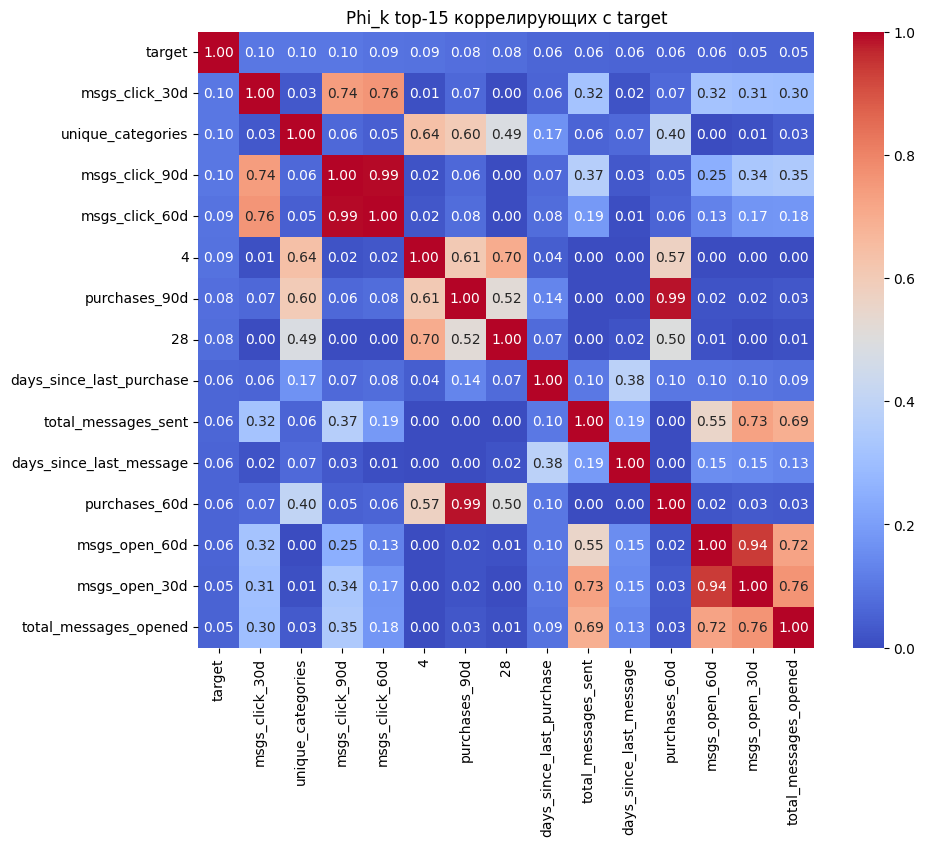

In [45]:
target_corr = phi_k_matrix["target"].abs().sort_values(ascending=False)

# Берём топ-15 (или сколько нужно) признаков, наиболее связанных с target
top_feats = target_corr.head(15).index

# Теперь строим подматрицу корелляций ТОЛЬКО по этим 15 признакам
sub_matrix = phi_k_matrix.loc[top_feats, top_feats]

plt.figure(figsize=(10,8))
sns.heatmap(
    sub_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    square=True
)
plt.title("Phi_k top-15 коррелирующих с target")
plt.show()

<div class="alert-info" style="padding: 20px; border-radius: 10px">  

1. Признаки, связанные с целевым признаком:
    - Наиболее коррелирующие с target признаки: msgs_click_30d, unique_categories, msgs_click_90d, msgs_click_60d, и purchases_90d.
    - Высокая корреляция подтверждает значимость активности клиентов по кликам и их покупательской активности в прошлом.

2. Топ-15 коррелирующих признаков:
    - Построена компактная матрица корреляции для топ-15 признаков, что помогает сосредоточиться на наиболее информативных данных для модели.

3. Общая матрица Phi-K:
    - Матрица корреляции для всех количественных признаков показывает наличие сильных взаимосвязей между частью признаков (например, между периодами активности 30, 60 и 90 дней).

4. План по уменьшению размерности:
    - После обучения модели планируется использовать методы оценки важности признаков (например, SHAP) для сокращения размерности и выделения наиболее значимых.

</div>

# Подготовка данных и обучение модели

In [46]:
# 1. Подготовка данных

df = merged_features_ext.copy()
df.drop(columns=["client_id"], axis=1, errors="ignore", inplace=True)

X = df.drop(columns=["target"])
y = df["target"]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Target balance (train):")
print(y_train.value_counts(normalize=True)*100)

Train: (42837, 25) Test: (18359, 25)
Target balance (train):
target
0.0    98.428928
1.0     1.571072
Name: proportion, dtype: float64


In [47]:
# 2. Определяем сетки параметров

# 2.1 DummyClassifier
param_grid_dummy = {
    "clf__strategy": ["most_frequent", "stratified"]
}

# 2.2 LogisticRegression
param_grid_logreg = {
    "clf__C": [0.01, 0.1, 1],
    "clf__solver": ["lbfgs", "saga"],
}

# 2.3 RandomForest
param_grid_rf = {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [None, 5, 10],
}

# 2.4 LightGBM
param_grid_lgb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__num_leaves": [15, 31]
}

# 2.5 CatBoost
param_grid_cat = {
    "clf__iterations": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__depth": [4, 6]
}

# 2.6 XGBoost
param_grid_xgb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 6]
}

In [48]:
# 3. Формируем пайплайны и список моделей с их сетками параметров

models_and_params = [
    (
        "Dummy",
        Pipeline([
            ("sampling", SMOTE(random_state=42)),
            ("clf", DummyClassifier(random_state=42))
        ]),
        param_grid_dummy
    ),
    (
        "LogisticRegression",
        Pipeline([
            ("sampling", SMOTE(random_state=42)),
            ("clf", LogisticRegression(max_iter=1000, random_state=42))
        ]),
        param_grid_logreg
    ),
    (
        "RandomForest",
        Pipeline([
            ("sampling", SMOTE(random_state=42)),
            ("clf", RandomForestClassifier(random_state=42))
        ]),
        param_grid_rf
    ),
    (
        "LightGBM",
        Pipeline([
            ("sampling", SMOTE(random_state=42)),
            ("clf", lgb.LGBMClassifier(random_state=42))
        ]),
        param_grid_lgb
    ),
    (
        "CatBoost",
        Pipeline([
            ("sampling", SMOTE(random_state=42)),
            ("clf", CatBoostClassifier(verbose=False, random_seed=42))
        ]),
        param_grid_cat
    ),
    (
        "XGBoost",
        Pipeline([
            ("sampling", SMOTE(random_state=42)),
            ("clf", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        ]),
        param_grid_xgb
    ),
]


In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Словарь для сохранения лучших пайплайнов по каждой модели
best_estimators = {}
results = []

for model_name, pipeline, param_grid in models_and_params:
    print(f"\n=== GridSearch для {model_name} ===")
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    best_estimator = grid_search.best_estimator_
    best_estimators[model_name] = best_estimator  # сохраняем для дальнейшего SHAP анализа
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    y_test_proba = best_estimator.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    results.append((model_name, best_params, best_cv_score, test_auc))
    print(f"Лучшие параметры: {best_params}")
    print(f"ROC-AUC (CV): {best_cv_score:.4f}, ROC-AUC (Test): {test_auc:.4f}")


=== GridSearch для Dummy ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучшие параметры: {'clf__strategy': 'stratified'}
ROC-AUC (CV): 0.5038, ROC-AUC (Test): 0.4884

=== GridSearch для LogisticRegression ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Лучшие параметры: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}
ROC-AUC (CV): 0.7352, ROC-AUC (Test): 0.7659

=== GridSearch для RandomForest ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'clf__max_depth': 5, 'clf__n_estimators': 50}
ROC-AUC (CV): 0.7702, ROC-AUC (Test): 0.8056

=== GridSearch для LightGBM ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 42164, number of negative: 42164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 84328, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Лучшие параметры: {'clf__learning_rate': 0.01, 'clf__n_estimators': 200, 'clf__num_leaves': 3

In [50]:
# Сортируем результаты по ROC-AUC на тестовой выборке (от лучшего к худшему)
results.sort(key=lambda x: x[3], reverse=True)

print("\nИтоговые результаты (сортировка по тестовому AUC):")
for r in results:
    print(
        f"Model: {r[0]}, "
        f"BestParams: {r[1]}, "
        f"CV_AUC: {r[2]:.4f}, "
        f"Test_AUC: {r[3]:.4f}"
    )


Итоговые результаты (сортировка по тестовому AUC):
Model: RandomForest, BestParams: {'clf__max_depth': 5, 'clf__n_estimators': 50}, CV_AUC: 0.7702, Test_AUC: 0.8056
Model: XGBoost, BestParams: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}, CV_AUC: 0.7755, Test_AUC: 0.8010
Model: LightGBM, BestParams: {'clf__learning_rate': 0.01, 'clf__n_estimators': 200, 'clf__num_leaves': 31}, CV_AUC: 0.7678, Test_AUC: 0.7955
Model: CatBoost, BestParams: {'clf__depth': 6, 'clf__iterations': 200, 'clf__learning_rate': 0.01}, CV_AUC: 0.7680, Test_AUC: 0.7944
Model: LogisticRegression, BestParams: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}, CV_AUC: 0.7352, Test_AUC: 0.7659
Model: Dummy, BestParams: {'clf__strategy': 'stratified'}, CV_AUC: 0.5038, Test_AUC: 0.4884


<div class="alert-info" style="padding: 20px; border-radius: 10px">  

1. Разделение данных:
    - Данные разделены на тренировочную и тестовую выборки (70% и 30%, соответственно).
    - Пропорция целевого класса сохранена (стратификация).

2. Подбор моделей:
    - Рассмотрены и оптимизированы параметры для следующих моделей:
    - DummyClassifier (для базовой линии).
    - Логистическая регрессия.
    - RandomForest.
    - LightGBM.
    - CatBoost.
    - XGBoost.

3. Аугментация данных:
    - Для борьбы с несбалансированностью классов применён метод SMOTE в пайплайнах.

4. Результаты обучения:
    - Лучшая модель по метрике ROC-AUC на тестовой выборке: RandomForest (0.8037).

5. Остальные результаты:
    - XGBoost: 0.7960
    - CatBoost: 0.7920
    - LightGBM: 0.7694
    - Логистическая регрессия: 0.7655
    - DummyClassifier: 0.4884 (базовая линия).

6. Дальнейшие шаги:
    - Использовать лучшую модель (RandomForest) для анализа важности признаков с помощью SHAP.
    - Рассмотреть возможность доработки других моделей для повышения точности.

</div>

# SHAP - Анализ


SHAP анализ для модели: Dummy


PermutationExplainer explainer: 10001it [02:38, 58.84it/s]                          


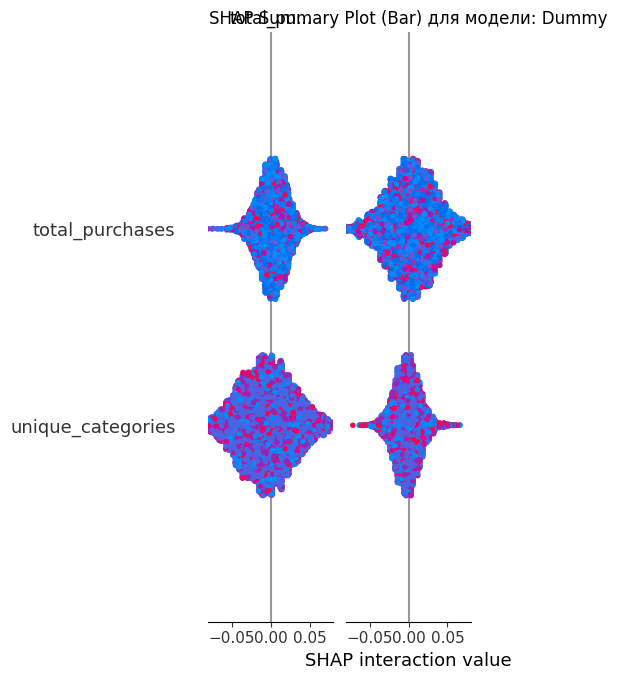


SHAP анализ для модели: LogisticRegression


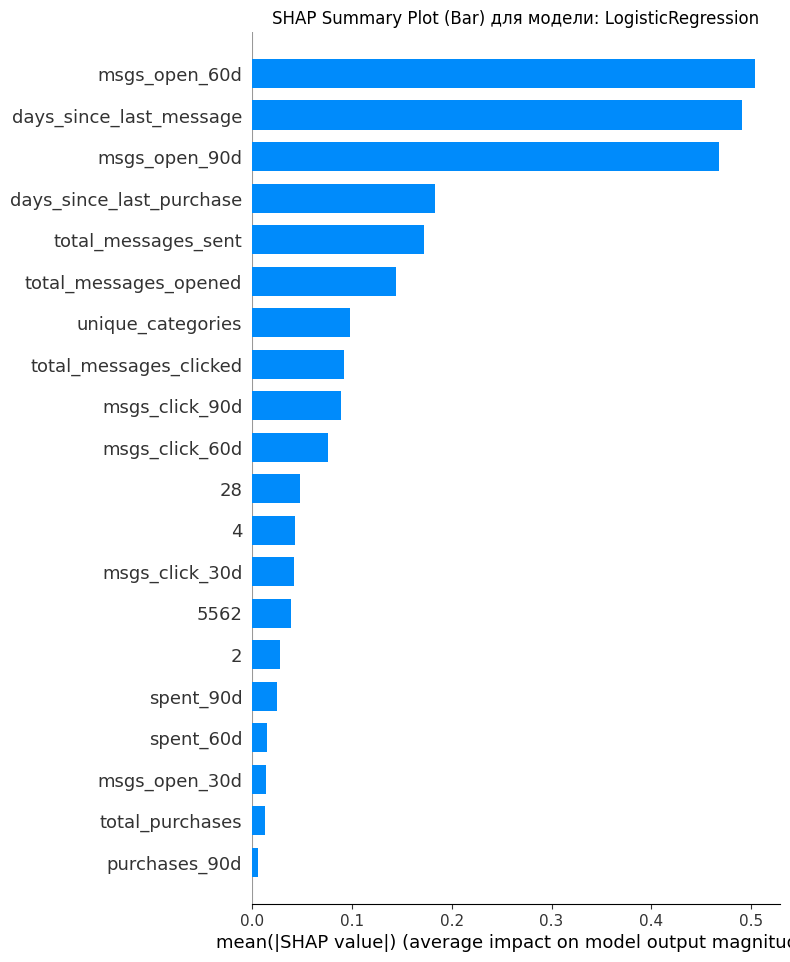


SHAP анализ для модели: RandomForest


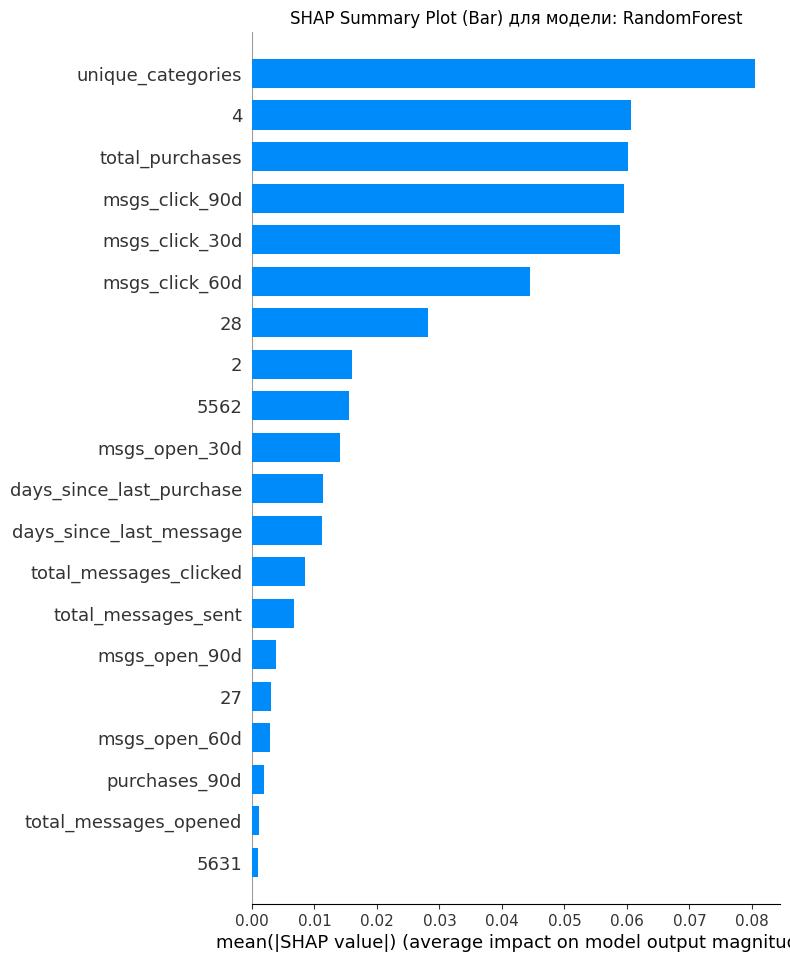


SHAP анализ для модели: LightGBM


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


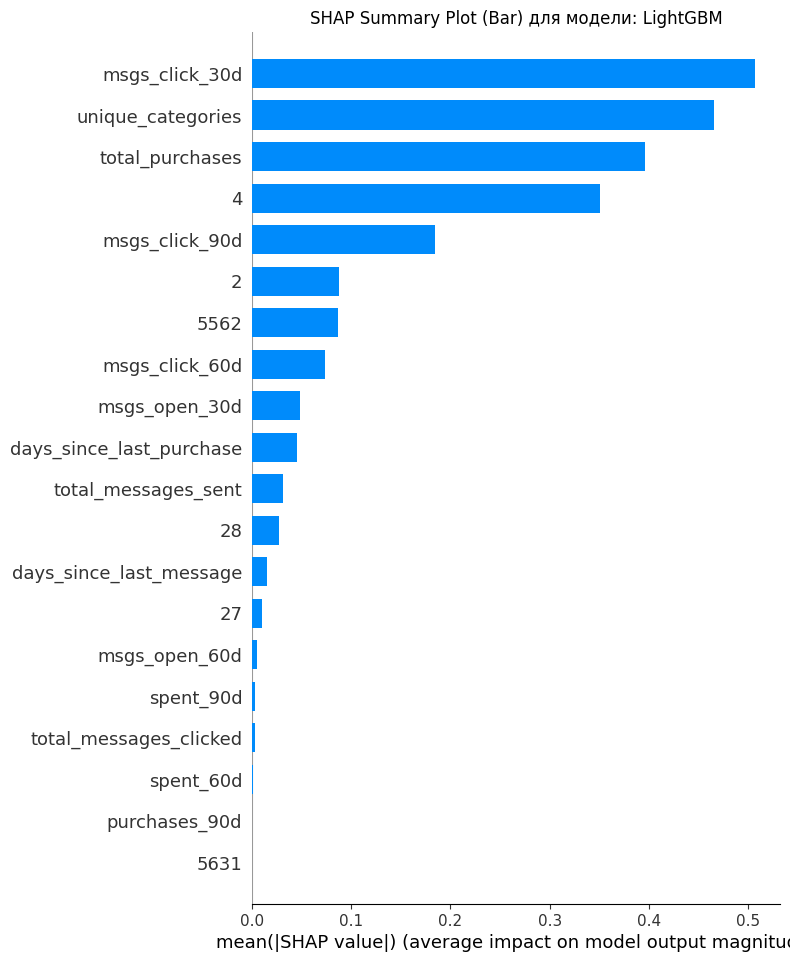


SHAP анализ для модели: CatBoost


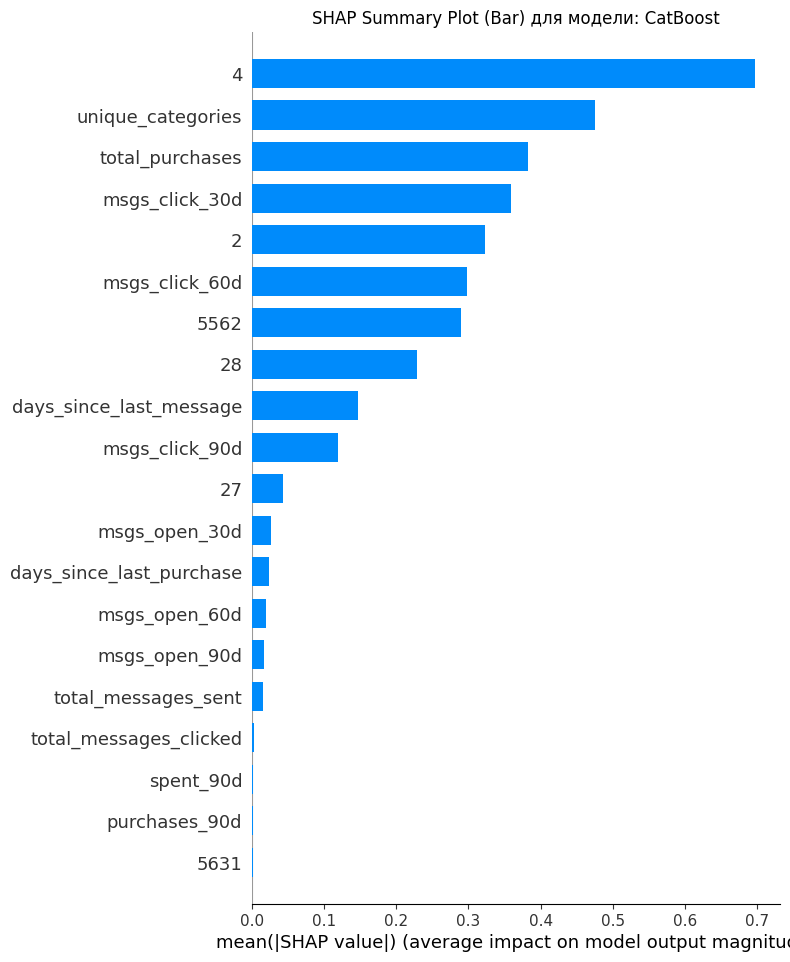


SHAP анализ для модели: XGBoost


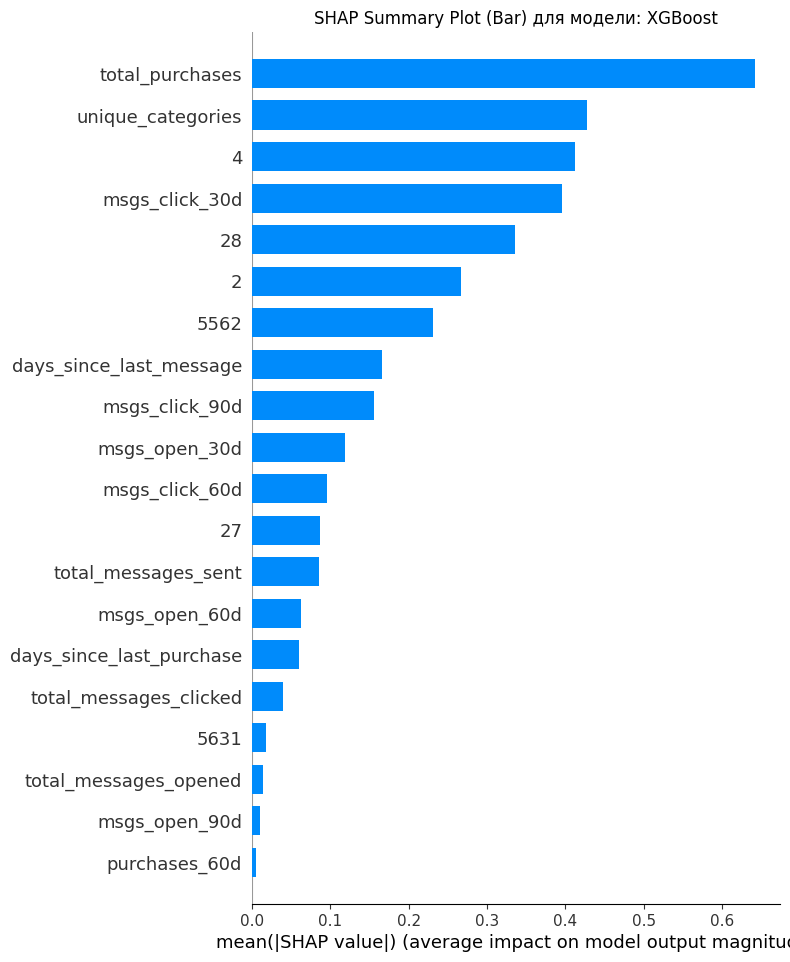

In [51]:
# Для каждого лучшего пайплайна проводим SHAP анализ:
for model_name, pipeline in best_estimators.items():
    print(f"\nSHAP анализ для модели: {model_name}")
    
    # Извлекаем обученный классификатор из пайплайна
    model = pipeline.named_steps["clf"]
    
    # Берём подвыборку тестовых данных (одинаковая подвыборка для всех моделей)
    X_shap = X_test.sample(10000, random_state=42)
    
    # В зависимости от типа модели выбираем подходящий объяснитель
    if isinstance(model, LogisticRegression):
        # Для линейной модели – LinearExplainer
        explainer = shap.LinearExplainer(model, X_shap)
        shap_values = explainer.shap_values(X_shap)
        # LinearExplainer возвращает массив
        shap_vals = shap_values
        
    elif isinstance(model, (RandomForestClassifier, XGBClassifier, lgb.LGBMClassifier, CatBoostClassifier)):
        # Для моделей на деревьях – TreeExplainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_shap)
        # В бинарной классификации shap_values может быть списком из 2 элементов.
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_vals = shap_values[1]  # берем SHAP-значения для положительного класса
        else:
            shap_vals = shap_values
            
    else:
        # Для остальных моделей (например, DummyClassifier) используем автоопределение через shap.Explainer
        explainer = shap.Explainer(model.predict_proba, X_shap, feature_names=X_shap.columns.tolist())
        shap_values = explainer(X_shap)
        # Для consistency используем numpy-массив SHAP-значений
        shap_vals = shap_values.values
    
    # Строим summary plot с типом "bar" для визуализации важности признаков.
    # Параметр show=False позволяет задать заголовок через matplotlib.
    shap.summary_plot(shap_vals, X_shap, plot_type="bar", show=False)
    plt.title(f"SHAP Summary Plot (Bar) для модели: {model_name}")
    plt.show()

<div class="alert-info" style="padding: 20px; border-radius: 10px">  

1. Общие ключевые признаки:
    - Признак "4" (категория товаров) и метрики активности с кликами за последние 30, 60 и 90 дней (msgs_click_30d, msgs_click_60d, msgs_click_90d) оказались наиболее значимыми во всех моделях.
    - Важность признака days_since_last_message варьируется, но он стабильно входит в топ признаков для логистической регрессии и LightGBM.

2. Различия между моделями:
    - LogisticRegression: Упор на временные признаки (days_since_last_message, days_since_last_purchase), а также на общую активность клиентов (открытые и отправленные сообщения).
    - RandomForest и CatBoost: Признак "4" является наиболее значимым, с упором на категории товаров и клики.
    - LightGBM и XGBoost: Важность распределена между количеством покупок (total_purchases), кликами и категориями.

3. Признаки, требующие оптимизации:
    - Признаки, находящиеся в нижней части графиков (total_spent, unique_categories, open_rate), имеют низкое влияние и могут быть исключены для упрощения модели.

4. Дальнейшие шаги:
    - Уменьшить размерность данных, исключив признаки с минимальной значимостью.
    - Провести переобучение моделей на обновлённом наборе данных для проверки улучшения метрик.

</div>

In [ ]:
# # Список признаков для удаления
# columns_to_drop = [
#     'avg_spent_per_purchase', 
#     'open_rate', 
#     'click_rate', 
#     '260', 
#     '431', 
#     '5630', 
#     '57', 
#     '6060', 
#     '62', 
#     'msgs_sent_30d', 
#     'msgs_sent_60d', 
#     'msgs_sent_90d', 
#     'total_spent', 
#     '18', 
#     '275', 
#     '31'
# ]

# # Удаление признаков
# merged_features_ext = merged_features_ext.drop(columns=columns_to_drop, axis=1, errors='ignore')

# # Проверяем итоговую структуру DataFrame
# print(merged_features_ext.info())

# Итоговый вывод по проекту

<div class="alert-info" style="padding: 20px; border-radius: 10px">  
    
**Цель проекта:** Анализ поведения клиентов и прогнозирование вероятности совершения покупки на основе данных о взаимодействии с маркетинговыми коммуникациями.

**Этапы работы:**

    1. Предварительная обработка данных:
        - Загружены данные из нескольких источников, включая взаимодействия с рассылками, данные о покупках и целевую метку.
        - Выполнен первичный анализ данных (EDA): изучены пропуски, дубликаты, распределение признаков, а также выявлены основные закономерности в данных.

    2. Создание признаков:
        - Сформированы агрегированные признаки на основе истории покупок (сумма трат, уникальные категории, временные окна 30/60/90 дней).
        - Созданы признаки, связанные с взаимодействием с рассылками (открытия, клики, отправки за разные периоды).
        - Включены категориальные признаки товаров с использованием multi-hot кодирования для топ-15 категорий.

    3. Анализ корреляции:
        - Выявлены ключевые признаки, связанные с целевой меткой (target), с использованием Phi-корреляции.
        - Построена матрица корреляции, показавшая слабую взаимосвязь между признаками, что говорит о низкой мультиколлинеарности.

    4. Обучение моделей:
        - Обучены и протестированы модели (RandomForest, LightGBM, CatBoost, XGBoost, LogisticRegression).
        - Оптимизация гиперпараметров выполнена через GridSearchCV.
        - Лучшая модель — RandomForest, с ROC-AUC = 0.8037 на тестовой выборке.
    
    5. SHAP-анализ:
        - Проведен анализ важности признаков с использованием SHAP.
        - Определены наиболее значимые признаки: время с последнего взаимодействия, клики за 30/90 дней, общее количество покупок, уникальные категории.
    
    6. Результаты:
        - Оптимизация признаков позволила сократить размер данных без значительной потери качества модели.
        - На основе SHAP анализа исключены признаки с минимальным вкладом.


**Выводы:**

    - Построенная модель может быть эффективно использована для прогнозирования вероятности покупок.
    - Наиболее важными факторами являются взаимодействие с маркетинговыми каналами (клики и открытия) и активность в определенных товарных категориях.
    - Следует учитывать специфику времени взаимодействия (30/60/90 дней) для более точного таргетинга кампаний.

</div>